# **O Desafio**

O naufrágio do Titanic é um dos naufrágios mais infames da história.

Em 15 de abril de 1912, durante sua viagem inaugural, o amplamente considerado "inafundável" RMS Titanic afundou após colidir com um iceberg. Infelizmente, não havia botes salva-vidas suficientes para todos a bordo, resultando na morte de 1502 dos 2224 passageiros e tripulantes.

Embora houvesse algum elemento de sorte envolvido na sobrevivência, parece que alguns grupos de pessoas tinham mais probabilidade de sobreviver do que outros.

Neste desafio, pedimos que você construa um modelo preditivo que responda à pergunta: “que tipos de pessoas tinham mais probabilidade de sobreviver?” usando dados de passageiros (ou seja, nome, idade, sexo, classe socioeconômica, etc.).

## Avaliação

## Meta
É seu trabalho prever se um passageiro sobreviveu ao naufrágio do Titanic ou não.
Para cada um no conjunto de teste, você deve prever um valor 0 ou 1 para a variável.

## Métrica
Sua pontuação é a porcentagem de passageiros que você prevê corretamente. Isso é conhecido como precisão .

## Formato do arquivo de submissão
Você deve enviar um arquivo csv com exatamente 418 entradas mais uma linha de cabeçalho. Seu envio mostrará um erro se você tiver colunas extras (além de PassengerId e Survived) ou linhas.

#### O arquivo deve ter exatamente 2 colunas:

- PassengerId (classificado em qualquer ordem)
- Sobreviveu (contém suas previsões binárias: 1 para sobreviveu, 0 para falecido)

## Descrição do conjunto de dados

### Visão geral

#### Os dados foram divididos em dois grupos:

- conjunto de treinamento (train.csv)
- conjunto de teste (test.csv)

## Dicionário de Dados

### Variável Definição
- sobrevivência -	Sobrevivência
- pclass - Classe de ingresso
- sexo - Sexo
- Idade -	Idade em anos
- irmão	- # de irmãos/cônjuges a bordo do Titanic
- ressecar - # de pais/crianças a bordo do Titanic
- bilhete	- Número do bilhete
- tarifa	- Tarifa de passageiro
- cabine	- Número da cabine
- embarcado -	Porto de embarque

### Notas Variáveis
- pclass : Um proxy para status socioeconômico (SES)
  - 1º = Alto
  - 2º = Médio
  - 3º = Baixo

- idade : A idade é fracionária se for menor que 1. Se a idade for estimada, ela está no formato de xx,5

- sibsp : O conjunto de dados define as relações familiares desta forma...
  - Irmão = irmão, irmã, meio-irmão, meia-irmã
  - Cônjuge = marido, esposa (amantes e noivos foram ignorados)

- parch : O conjunto de dados define as relações familiares desta forma...
  - Pai = mãe, pai
  - Filho = filha, filho, enteada, enteado
  - Algumas crianças viajaram apenas com
  uma babá, portanto parch=0 para elas.

# Setup

In [1]:
%%capture
%pip install ydata-profiling
%pip install catboost

In [ ]:
import pandas as pd
import ydata_profiling
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV


import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Data Clean

In [62]:
raw_df_train = pd.read_csv('/content/drive/MyDrive/Projetos/Data Science/0 Projeto /Dados/train.csv')

raw_df_test = pd.read_csv('/content/drive/MyDrive/Projetos/Data Science/0 Projeto /Dados/test.csv')

y_real = pd.read_csv('/content/drive/MyDrive/Projetos/Data Science/0 Projeto /Dados/gender_submission.csv')

In [4]:
raw_df_train.profile_report()

Output hidden; open in https://colab.research.google.com to view.

In [5]:
(
    raw_df_train.groupby('Sex')['Survived']
    .value_counts(normalize=True)
    .mul(100)  # Multiplica por 100 para percentual
    .round(2)  # Arredonda para 2 casas decimais
    .unstack()
    .astype(str) + '%'  # Converte para string e adiciona '%'
)

Survived,0,1
Sex,,
female,25.8%,74.2%
male,81.11%,18.89%


In [6]:
raw_df_train.groupby('SibSp')['Survived'].value_counts().unstack().assign(

    # Adiciona uma coluna como total
    Total=lambda raw_df_train: raw_df_train.sum(axis=1),

    # % de sobreviventes
    Sobreviventes=lambda raw_df_train: (raw_df_train[1] / raw_df_train['Total'] * 100).round(2).astype(str) + '%',

    # % de não sobreviventes
    Não_Sobreviventes=lambda raw_df_train: (raw_df_train[0] / raw_df_train['Total'] * 100).round(2).astype(str) + '%'
  )

Survived,0,1,Total,Sobreviventes,Não_Sobreviventes
SibSp,,,,,
0,398.0,210.0,608.0,34.54%,65.46%
1,97.0,112.0,209.0,53.59%,46.41%
2,15.0,13.0,28.0,46.43%,53.57%
3,12.0,4.0,16.0,25.0%,75.0%
4,15.0,3.0,18.0,16.67%,83.33%
5,5.0,NaN,5.0,nan%,100.0%
8,7.0,NaN,7.0,nan%,100.0%


In [7]:
# Definir faixas etárias
bins = [0, 12, 18, 30, 45, 60, 100]
labels = ['Criança (0-12)', 'Adolescente (13-18)', 'Jovem Adulto (19-30)',
          'Adulto (31-45)', 'Meia Idade (46-60)', 'Idoso (61+)']

# Número total de passageiros
total_geral = raw_df_train.shape[0]

# Agrupar por faixas etárias sem criar uma nova coluna
(
  raw_df_train.groupby([
      pd.cut(
          raw_df_train['Age'],
          bins=bins,
          labels=labels
          ),
      'Pclass'
      ])['Survived']
  .value_counts()
  .unstack().assign(

    # Adiciona uma coluna como total
    Total=lambda raw_df_train: raw_df_train.sum(axis=1),

    # % de sobreviventes
    Sobreviventes=lambda raw_df_train: (raw_df_train[1] / raw_df_train['Total'] * 100).round(2).astype(str) + '%',

    # % de não sobreviventes
    Não_Sobreviventes=lambda raw_df_train: (raw_df_train[0] / raw_df_train['Total'] * 100).round(2).astype(str) + '%',

    # % do total geral de passageiros (independente da faixa etária)
    Total_Geral_Percent=lambda raw_df_train: (raw_df_train['Total'] / total_geral * 100).round(2).astype(str) + '%'
  )
)

<ipython-input-7-553263385e8c>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  raw_df_train.groupby([


Survived                       0   1  Total Sobreviventes Não_Sobreviventes  \
Age                  Pclass                                                   
Criança (0-12)       1         1   3      4         75.0%             25.0%   
                     2         0  17     17        100.0%              0.0%   
                     3        28  20     48        41.67%            58.33%   
Adolescente (13-18)  1         1  11     12        91.67%             8.33%   
                     2         6   6     12         50.0%             50.0%   
                     3        33  13     46        28.26%            71.74%   
Jovem Adulto (19-30) 1        13  32     45        71.11%            28.89%   
                     2        39  28     67        41.79%            58.21%   
                     3       122  36    158        22.78%            77.22%   
Adulto (31-45)       1        17  46     63        73.02%            26.98%   
                     2        29  25     54         46.3%             53.7%   
                     3        70  15     85        17.65%            82.35%   
Meia Idade (46-60)   1        21  27     48        56.25%            43.75%   
                     2        14   6     20         30.0%             70.0%   
                     3        13   0     13          0.0%            100.0%   
Idoso (61+)          1        11   3     14        21.43%            78.57%   
                     2         2   1      3        33.33%            66.67%   
                     3         4   1      5         20.0%             80.0%   

Survived                    Total_Geral_Percent  
Age                  Pclass                      
Criança (0-12)       1                    0.45%  
                     2                    1.91%  
                     3                    5.39%  
Adolescente (13-18)  1                    1.35%  
                     2                    1.35%  
                     3                    5.16%  
Jovem Adulto (19-30) 1                    5.05%  
                     2                    7.52%  
                     3                   17.73%  
Adulto (31-45)       1                    7.07%  
                     2                    6.06%  
                     3                    9.54%  
Meia Idade (46-60)   1                    5.39%  
                     2                    2.24%  
                     3                    1.46%  
Idoso (61+)          1                    1.57%  
                     2                    0.34%  
                     3                    0.56%

Sabendo disto agora vamos tratar os dados

<Axes: >

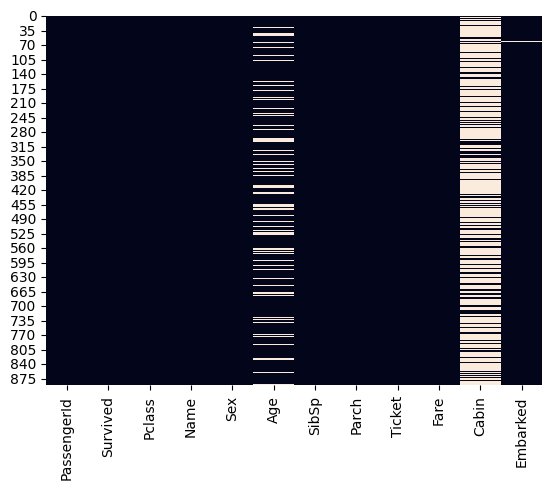

In [8]:
sns.heatmap(raw_df_train.isnull(), cbar=False)

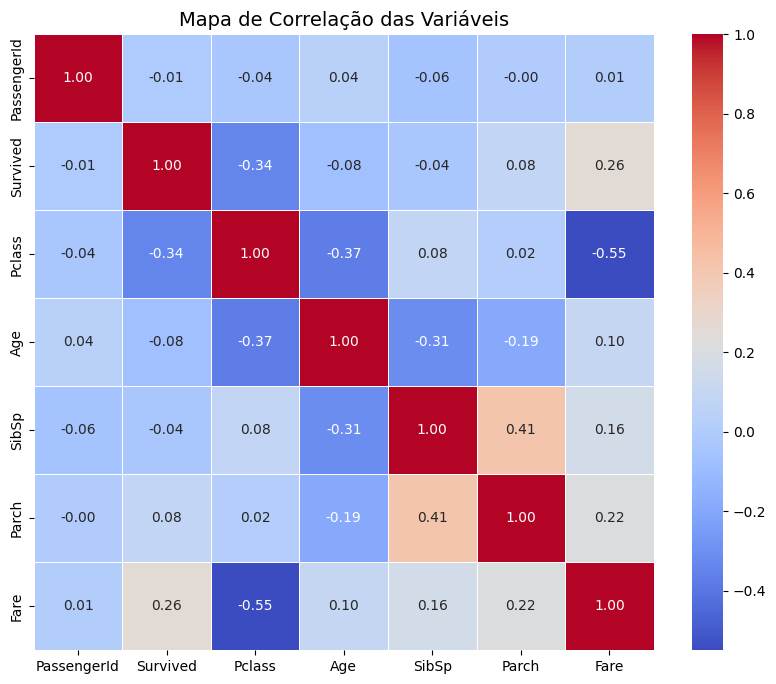

In [9]:
# Calcular a matriz de correlação
correlation_matrix = raw_df_train.corr(numeric_only=True)

# Criar o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Título do gráfico
plt.title("Mapa de Correlação das Variáveis", fontsize=14)
plt.show()

In [10]:
# raw_df_train['Age'].interpolate()
raw_df_train['Age'] = raw_df_train.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

raw_df_train['Embarked'] = raw_df_train['Embarked'].fillna(raw_df_train['Embarked'].mode()[0])

raw_df_train.drop('Cabin', axis=1, inplace=True)

In [11]:
# Criando o objeto LabelEncoder
lb = LabelEncoder()

# Aplicando o LabelEncoder para cada coluna de tipo 'object'
for col in raw_df_train.select_dtypes(include=['object']).columns:
    raw_df_train[col] = lb.fit_transform(raw_df_train[col])

# Verificando o resultado
raw_df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,108,1,22.0,1,0,523,7.2500,2
1,2,1,1,190,0,38.0,1,0,596,71.2833,0
2,3,1,3,353,0,26.0,0,0,669,7.9250,2
3,4,1,1,272,0,35.0,1,0,49,53.1000,2
4,5,0,3,15,1,35.0,0,0,472,8.0500,2


In [12]:
# Calcular a informação mútua
mi = mutual_info_classif(raw_df_train.drop(columns=['Survived']), raw_df_train['Survived'])

# Criando um DataFrame para exibir as informações mútuas
mi_df = pd.DataFrame({
    'Feature': raw_df_train.drop(columns=['Survived']).columns,
    'Mutual Information': mi
})

mi_df.sort_values(by='Mutual Information', ascending=False)

,Feature,Mutual Information
3,Sex,0.136698
8,Fare,0.133377
7,Ticket,0.116203
1,Pclass,0.061569
4,Age,0.053444
6,Parch,0.042691
9,Embarked,0.041458
5,SibSp,0.033162
0,PassengerId,0.020517
2,Name,0.000000


In [13]:
# Ordenando as variáveis pela informação mútua (maior valor primeiro)
mi_df_sorted = mi_df.sort_values(by='Mutual Information', ascending=False)

# Selecionando as 5 variáveis mais representativas (maior informação mútua)
# Caso o número de variáveis seja menor que 5, ele pega todas as variáveis
top_5_features = mi_df_sorted.head(5)['Feature']

# Criando um novo DataFrame com as variáveis mais representativas
raw_df_selected = raw_df_train[top_5_features]

# Usando o merge para adicionar a coluna 'Survived' com base no índice
raw_df_selected = raw_df_selected.merge(raw_df_train[['Survived']], left_index=True, right_index=True)

In [14]:
raw_df_selected.head()

,Sex,Fare,Ticket,Pclass,Age,Survived
0,1,7.2500,523,3,22.0,0
1,0,71.2833,596,1,38.0,1
2,0,7.9250,669,3,26.0,1
3,0,53.1000,49,1,35.0,1
4,1,8.0500,472,3,35.0,0


In [15]:
raw_df_test['Age'] = raw_df_test.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

raw_df_test['Embarked'] = raw_df_test['Embarked'].fillna(raw_df_test['Embarked'].mode()[0])

raw_df_test['Fare'] = raw_df_test['Fare'].fillna(raw_df_test['Fare'].median())

raw_df_test.drop('Cabin', axis=1, inplace=True)

# Criando o objeto LabelEncoder
lb = LabelEncoder()

# Aplicando o LabelEncoder para cada coluna de tipo 'object'
for col in raw_df_test.select_dtypes(include=['object']).columns:
    raw_df_test[col] = lb.fit_transform(raw_df_test[col])

# Criando um novo DataFrame com as variáveis mais representativas
raw_df_selected_test = raw_df_test[top_5_features]

raw_df_selected_test.head()

,Sex,Fare,Ticket,Pclass,Age
0,1,7.8292,152,3,34.5
1,0,7.0000,221,3,47.0
2,1,9.6875,73,2,62.0
3,1,8.6625,147,3,27.0
4,0,12.2875,138,3,22.0


# Modeling

In [27]:
X_train = raw_df_selected.drop(columns='Survived')
y_train = raw_df_selected['Survived']

X_test = raw_df_selected_test
y_test = y_real['Survived']

In [17]:
# Definindo os modelos e os grids de parâmetros para o GridSearchCV
models = {
    'XGBoost': {
        'model': xgb.XGBClassifier(
            objective='binary:logistic',  # Tipo de problema binário (classificação binária)
            eval_metric='logloss',  # Métrica de avaliação para log loss
            verbosity=0,  # Controla a quantidade de mensagens de log
            booster='gbtree',  # Tipo de booster, usando árvores
            n_estimators=100,  # Número de árvores
            learning_rate=0.1,  # Taxa de aprendizado
            max_depth=7,  # Profundidade máxima das árvores
            min_child_weight=1,  # Peso mínimo por nó
            gamma=0,  # Regularização
            subsample=1,  # Subamostragem
            colsample_bytree=1  # Subamostragem por árvore
        ),
        'param_grid': {
            'model__learning_rate': [0.1, 0.2],  # Taxa de aprendizado
            'model__n_estimators': [100, 200],  # Número de árvores
            'model__max_depth': [3, 5],  # Profundidade das árvores
            'model__gamma': [0, 1],  # Regularização
            'model__min_child_weight': [1, 5],  # Peso mínimo por nó
            'model__subsample': [0.8, 1.0],  # Subamostragem
            'model__colsample_bytree': [0.8, 1.0]  # Subamostragem por árvore
        },
        'explanation': "XGBoost é um algoritmo de boosting eficiente. 'objective' define a tarefa (classificação binária), 'eval_metric' é a métrica usada, 'learning_rate' controla a taxa de aprendizado, 'max_depth' é a profundidade das árvores, e 'subsample' e 'colsample_bytree' ajudam a prevenir overfitting."
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(
            objective='binary',  # Tipo de problema binário
            metric='binary_error',  # Métrica de erro binário
            verbose=-1,  # Suprime logs
            num_leaves=50,  # Número de folhas por árvore
            max_depth=7,  # Profundidade das árvores
            learning_rate=0.1,  # Taxa de aprendizado
            n_estimators=100  # Número de árvores
        ),
        'param_grid': {
            'model__learning_rate': [0.01, 0.1],  # Taxa de aprendizado
            'model__n_estimators': [100, 200],  # Número de árvores
            'model__max_depth': [3, 5],  # Profundidade das árvores
            'model__num_leaves': [31, 50],  # Número de folhas por árvore
            'model__min_child_samples': [10, 20],  # Número mínimo de amostras por folha
            'model__subsample': [0.8, 1.0],  # Subamostragem
            'model__colsample_bytree': [0.8, 1.0],  # Subamostragem por árvore
            'model__min_split_gain': [0.0, 0.1]  # Ganho mínimo para dividir um nó
        },
        'explanation': "LightGBM é um algoritmo de boosting eficiente. 'objective' define a tarefa (classificação binária), 'metric' especifica a métrica de erro, 'learning_rate' controla a taxa de aprendizado, 'num_leaves' ajusta a complexidade das árvores, e 'subsample' e 'colsample_bytree' ajudam a evitar overfitting."
    },
    'CatBoost': {
        'model': CatBoostClassifier(
            iterations=1000,  # Número de iterações (ou árvores)
            depth=6,  # Profundidade das árvores
            learning_rate=0.1,  # Taxa de aprendizado
            loss_function='Logloss',  # Função de perda para classificação binária
            verbose=0  # Suprime logs
        ),
        'param_grid': {
            'model__iterations': [500, 1000],  # Número de iterações (ou árvores)
            'model__depth': [6, 10],  # Profundidade das árvores
            'model__learning_rate': [0.01, 0.1],  # Taxa de aprendizado
            'model__l2_leaf_reg': [3, 5],  # Regularização L2
            'model__border_count': [32, 64],  # Número de bordas para histograma
            'model__custom_metric': ['AUC', 'Logloss']  # Métricas personalizadas
        },
        'explanation': "CatBoost é um algoritmo eficiente, especialmente em dados categóricos. 'iterations' define o número de árvores, 'depth' controla a profundidade das árvores, e 'learning_rate' ajusta a taxa de aprendizado. 'l2_leaf_reg' ajuda na regularização, e 'border_count' controla o binning de variáveis contínuas."
    },
    'RandomForest': {
        'model': RandomForestClassifier(
            n_estimators=100,  # Número de árvores
            max_depth=7,  # Profundidade máxima das árvores
            min_samples_split=2,  # Número mínimo de amostras para dividir um nó
            min_samples_leaf=1,  # Número mínimo de amostras por folha
            max_features='auto',  # Número máximo de características por divisão
            bootstrap=True  # Amostragem com reposição
        ),
        'param_grid': {
            'model__n_estimators': [100, 200],  # Número de árvores
            'model__max_depth': [3, 5],  # Profundidade máxima das árvores
            'model__min_samples_split': [2, 5],  # Número mínimo de amostras para dividir um nó
            'model__min_samples_leaf': [1, 2],  # Número mínimo de amostras por folha
            'model__max_features': ['auto', 'sqrt'],  # Número máximo de características por divisão
            'model__bootstrap': [True, False]  # Se a amostragem é com reposição
        },
        'explanation': "Random Forest é um conjunto de árvores de decisão. 'n_estimators' define o número de árvores, 'max_depth' controla a profundidade, e 'min_samples_split' e 'min_samples_leaf' ajudam a prevenir overfitting. 'max_features' e 'bootstrap' controlam a aleatoriedade do modelo."
    },
    'SVM': {
        'model': SVC(
            kernel='rbf',  # Tipo de kernel
            C=1,  # Penalização do modelo
            gamma='scale',  # Função de kernel
            coef0=0,  # Coeficiente para kernel 'poly' ou 'sigmoid'
            class_weight=None,  # Peso das classes (útil para desequilíbrio)
            shrinking=True,  # Heurísticas de shrinking para otimização
            tol=1e-3  # Critério de parada
        ),
        'param_grid': {
            'model__C': [0.1, 1],  # Penalização do modelo
            'model__kernel': ['linear', 'rbf'],  # Tipo de kernel
            'model__gamma': ['scale', 'auto'],  # Função de kernel
            'model__degree': [3, 5],  # Grau do polinômio (para kernel 'poly')
            'model__coef0': [0, 1],  # Coeficiente da função de kernel (para kernel 'poly' ou 'sigmoid')
            'model__class_weight': ['balanced', None],  # Peso das classes
            'model__shrinking': [True, False],  # Heurísticas de shrinking
            'model__tol': [1e-3, 1e-4]  # Critério de parada
        },
        'explanation': "SVM é um classificador baseado em margens. 'C' controla a penalização dos erros, 'kernel' define a função de transformação dos dados, 'gamma' controla a forma do kernel, e 'class_weight' pode ser útil para desequilíbrio de classes. 'degree' e 'coef0' são relevantes para o kernel 'poly', e 'shrinking' ajuda a acelerar o treinamento."
    }
}

In [36]:
best_models = {}
best_scores = {}
best_params = {}

# Pipeline e otimização com RandomizedSearchCV
def random_search(model_name, model, param_grid):
    # Se o modelo for XGBoost, treinamos sem o Pipeline
    if model_name == 'XGBoost':
        print(f"Treinando {model_name} sem RandomizedSearchCV...")

        # Escalando as variáveis manualmente
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Treinando o modelo diretamente
        model.fit(X_train_scaled, y_train)

        # Avaliando a performance
        y_pred = model.predict(X_test_scaled)
        score = accuracy_score(y_test, y_pred)
        print(f"Relatório de classificação para {model_name}:\n", classification_report(y_test, y_pred))

        # Salvando o melhor modelo, parâmetros e pontuação
        best_models[model_name] = model
        best_scores[model_name] = score
        best_params[model_name] = None  # Nenhum parâmetro otimizado para XGBoost

    else:
        print(f"Realizando RandomizedSearchCV para {model_name}...")

        # Criando o pipeline com escala de dados
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Padronizando os dados
            ('model', model)               # O modelo
        ])

        # Configurando o RandomizedSearchCV
        random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=10, cv=5, n_jobs=-1, verbose=1, scoring='accuracy', random_state=42)

        # Treinando o modelo com os dados de treinamento
        random_search.fit(X_train, y_train)

        # Avaliando os melhores parâmetros e a performance
        print(f"Melhores parâmetros para {model_name}: {random_search.best_params_}")
        print(f"Melhor score para {model_name}: {random_search.best_score_}")
        y_pred = random_search.best_estimator_.predict(X_test)
        print(f"Relatório de classificação para {model_name}:\n", classification_report(y_test, y_pred))

        # Salvando o melhor modelo, parâmetros e pontuação
        best_models[model_name] = random_search.best_estimator_
        best_scores[model_name] = random_search.best_score_
        best_params[model_name] = random_search.best_params_

In [37]:
# Realizar o RandomizedSearchCV para todos os modelos
for model_name, model_info in models.items():
    random_search(model_name, model_info['model'], model_info['param_grid'])

Treinando XGBoost sem RandomizedSearchCV...
Relatório de classificação para XGBoost:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       266
           1       0.89      0.82      0.86       152

    accuracy                           0.90       418
   macro avg       0.90      0.88      0.89       418
weighted avg       0.90      0.90      0.90       418

Realizando RandomizedSearchCV para LightGBM...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Melhores parâmetros para LightGBM: {'model__subsample': 0.8, 'model__num_leaves': 50, 'model__n_estimators': 200, 'model__min_split_gain': 0.1, 'model__min_child_samples': 10, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1.0}
Melhor score para LightGBM: 0.8339087314041805
Relatório de classificação para LightGBM:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93       266
           1       0.87      0.86      0.87       152

    accuracy                           0.90       418
   macro avg       0.90      0.90      0.90       418
weighted avg       0.90      0.90      0.90       418

Realizando RandomizedSearchCV para CatBoost...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores parâmetros para CatBoost: {'model__learning_rate': 0.01, 'model__l2_leaf_reg': 3, 'model__iterations': 1000, 'model__depth': 6, 'model__custom_metric': 'Logloss', 'model__border_count': 64}
Melhor score par

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

Melhores parâmetros para RandomForest: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 5, 'model__bootstrap': False}
Melhor score para RandomForest: 0.8159751428033394
Relatório de classificação para RandomForest:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       266
           1       0.91      0.89      0.90       152

    accuracy                           0.93       418
   macro avg       0.92      0.92      0.92       418
weighted avg       0.93      0.93      0.93       418

Realizando RandomizedSearchCV para SVM...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores parâmetros para SVM: {'model__tol': 0.001, 'model__shrinking': True, 'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__degree': 3, 'model__coef0': 1, 'model__class_weight': None, 'model__C': 1}
Melhor score para SVM: 0.8013621241604418
Relatório 

In [40]:
best_svm_model = best_models['SVM']

In [38]:
best_models['SVM']

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC(C=1, coef0=1))])

In [41]:
y_pred = best_svm_model.predict(X_test)
print("Relatório de classificação para SVM:\n", classification_report(y_test, y_pred))

Relatório de classificação para SVM:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       266
           1       0.93      0.93      0.93       152

    accuracy                           0.95       418
   macro avg       0.95      0.95      0.95       418
weighted avg       0.95      0.95      0.95       418



In [55]:
# Vamos garantir a ordem correta, pode fazer o merge explicitamente:
SVM_predict = raw_df_test[['PassengerId']].assign(Survived=y_pred)

SVM_predict.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [56]:
SVM_predict.shape

(418, 2)

In [57]:
# Salvar o DataFrame final_df como um arquivo CSV
SVM_predict.to_csv('SVM_predict.csv', index=False)

In [60]:
#!pip freeze > requirements.txt

%%writefile requirements.txt
ydata-profiling
catboost
pandas
matplotlib
seaborn
scikit-learn
xgboost
lightgbm

Writing requirements.txt


In [61]:
!pip freeze | grep -E 'ydata-profiling|catboost|pandas|matplotlib|seaborn|scikit-learn|xgboost|lightgbm' > requirements_versa_do_codigo.txt

#**🔹 Análise da Sobrevivência no Titanic**


## 1️⃣ Relação entre Faixa Etária, Classe Social e Taxa de Sobrevivência
Os dados mostram que a chance de sobrevivência variou muito conforme a idade e a classe social.

📌 Faixa etária: Crianças tiveram maior chance de sobreviver, enquanto idosos tiveram a menor.<br>
📌 Classe social: Passageiros da 1ª classe sobreviveram muito mais do que os da 2ª e 3ª classe.<br><br>


## 2️⃣ Impacto da Classe Social na Taxa de Sobrevivência
A taxa de sobrevivência diminui drasticamente conforme a classe social cai:
  * 1ª classe: Taxas de sobrevivência altas (maior acesso a botes, localização privilegiada).
  * 2ª classe: Sobrevivência intermediária (menos acesso, mas ainda privilegiados em relação à 3ª classe).
  * 3ª classe: Sobrevivência baixa (dificuldade de acesso aos botes e barreiras físicas).<br>
  ### 🔴 Exemplo concreto:
    * Jovens adultos (19-30 anos) da 1ª classe tiveram 71,11% de sobrevivência, enquanto os da 3ª classe tiveram apenas 22,78%.

Esse padrão se repete para quase todas as faixas etárias.<br><br>


## 3️⃣ Explicações Possíveis
Agora, vamos entender por que a classe social impactou tanto a sobrevivência.

🔹 Fatores que favoreceram os passageiros da 1ª classe:<br>
✔ Localização privilegiada: A 1ª classe ficava nos andares superiores, próxima aos botes.<br>
✔ Menos barreiras físicas: Passageiros da 3ª classe enfrentaram portões fechados, dificultando a fuga.<br>
✔ Privilégio no resgate: A tripulação priorizou passageiros da 1ª classe.<br>

🔹 Fatores que prejudicaram os passageiros da 3ª classe:<br>
❌ Distância dos botes: Estavam nos andares inferiores, longe das saídas.<br>
❌ Bloqueios da tripulação: Relatos históricos indicam que alguns passageiros foram impedidos de subir.<br>
❌ Menor acesso à informação: Possivelmente demoraram mais para perceber a gravidade do naufrágio.<br><br>


## 4️⃣ Conclusão
📌 A classe social foi um dos fatores mais determinantes para a sobrevivência no Titanic.<br>
📌 Mulheres e crianças foram priorizadas, mas mesmo assim a 3ª classe teve grande desvantagem.<br>
📌 A localização dos camarotes e o acesso aos botes salvaram muitas vidas da 1ª classe.